In [0]:
#Google ColaboratoryとGCPプロジェクトを接続する

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

In [0]:
#パッケージをインポートする

import pandas as pd
import scipy as sp
from scipy import optimize
from decimal import Decimal
import numpy as np
import os
import random
import collections


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

#plt.style.use('ggplot')
#font = {'family':'Osaka'}
#font = {'family':'IPAPGothic'}
#matplotlib.rc('font', **font)

from datetime import datetime

#データ格納元となっている、GCPプロジェクトを指定する
project_id = 'dharma-2nd-arata-naoya'
from google.cloud import bigquery
client = bigquery.Client(project = project_id)

!pip install googletrans
#!pip install googlemaps #必要なときだけインストール
!pip install tqdm
from tqdm import tqdm_notebook as tqdm
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)

import pickle

  Created wheel for googletrans: filename=googletrans-2.4.0-cp36-none-any.whl size=15776 sha256=5da5fe93a1f8e1473f294e30e03231aa8549769f6e6df8d5c19b80a68fc1768f
  Stored in directory: /root/.cache/pip/wheels/50/d6/e7/a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
Successfully built googletrans


In [0]:
#JR東日本の乗客人数ランキング（2018年度）より、乗客人数の多い上位100駅を抽出

import requests
from bs4 import BeautifulSoup
import csv

url = 'https://www.jreast.co.jp/passenger/'
response = requests.get(url)
response.encoding = response.apparent_encoding

soup = BeautifulSoup(response.text, 'html.parser')
station = soup.find_all(class_="stationName")

csvlist = []
for a in station:
    csvlist.append(a.text)

f = open("station.csv", "w")
writecsv = csv.writer(f, lineterminator='\n')

writecsv.writerow(csvlist)

f.close()


In [0]:
#一度ローカルに保存したcsvファイルを、colab上にアップロード

from google.colab import files
uploaded = files.upload()

Saving station.csv to station.csv


In [0]:
#ファイル内容の確認

import pandas as pd
import io
data = pd.read_csv(io.StringIO(uploaded['station.csv'].decode('utf-8')), header=None)

pd.set_option('display.max_rows', 10000)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_rows", 101)

data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,新宿,池袋,東京,横浜,品川,渋谷,新橋,大宮,秋葉原,北千住,川崎,高田馬場,上野,大崎,有楽町,立川,浜松町,田町,中野,恵比寿,蒲田,吉祥寺,五反田,西船橋,船橋,...,蕨,市川,長津田,南浦和,本八幡,辻堂,東戸塚,大塚,西川口,亀戸,新浦安,茅ケ崎,関内,さいたま新都心,浅草橋,菊名,国立,武蔵浦和,北浦和,高円寺,金町,新大久保,稲毛,駒込,田端


In [0]:
#このままではBQに入りそうにないため、横持ちから縦持ちのデータに変換する

data_2 = data.stack()
data_2.head()

0  0    新宿
   1    池袋
   2    東京
   3    横浜
   4    品川
dtype: object

In [0]:
from google.colab import files
data_2.to_csv("stations.csv")
files.download('stations.csv') 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


タクシーのODデータ、駅の判別用データがひとまず作成できた。<br>
出来たデータを観察してみる

In [0]:
#乗車地点の観察
#ODデータより乗車（空車→実車）のデータのみ抽出

#クエリの作成
query_1 = """
SELECT
  point,
  before,
  after,
  StatusTime
FROM
  `dharma-2nd-arata-naoya.dac2019.dac2019_sample_1pml_1571663091545_OD`
WHERE
  before = '空車'
  AND after = '実車'
"""

#今回は全体を見たいため、会社や運転手は判別しない

#クエリ結果をpandasのデータフレームに格納
results_1 = client.query(query_1).to_dataframe()

#表示範囲を指定する
pd.set_option('display.max_rows', 10000)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_rows", 101)

#クエリ結果を表示
results_1

,point,before,after,StatusTime
0,POINT(139.7675062 35.5448807),空車,実車,2016-08-11 18:18:06
1,POINT(139.66748 35.655801),空車,実車,2016-08-11 19:09:24
2,POINT(139.7458396 35.6573813),空車,実車,2016-08-11 20:37:53
3,POINT(139.7456205 35.657183),空車,実車,2016-08-11 21:48:06
4,POINT(139.72785 35.65971),空車,実車,2016-08-11 22:48:38
...,...,...,...,...
184074,POINT(139.54814943923 35.7615644691469),空車,実車,2018-01-28 02:12:07
184075,POINT(139.57265435306 35.7313042449459),空車,実車,2018-01-28 02:24:23
184076,POINT(139.617618425896 35.7065382348914),空車,実車,2018-01-28 02:47:58
184077,POINT(139.577141407167 35.7027323793876),空車,実車,2018-01-28 03:06:27


In [0]:
#乗車地点がターミナル駅かどうかの判別

#クエリの作成
query_2 = """
SELECT
  A.station_name,
  ST_CONTAINS(A.region,
    B.point) AS judg,
  B.before,
  B.after,
  B.StatusTime
FROM
  `dharma-2nd-arata-naoya.dac2019.stations_terminal_region_2` AS A
INNER JOIN (
  SELECT
    point,
    before,
    after,
    StatusTime
  FROM
    `dharma-2nd-arata-naoya.dac2019.dac2019_sample_1pml_1571663091545_OD`
  WHERE
    before = '空車'
    AND after = '実車'
  ORDER BY
    StatusTime ASC) AS B
ON
  1 = 1
"""


#クエリ結果をpandasのデータフレームに格納
results_2 = client.query(query_2).to_dataframe()

#表示範囲を指定する
pd.set_option('display.max_rows', 10000)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_rows", 101)

#クエリ結果を表示
results_2

,station_name,judg,before,after,StatusTime
0,亀戸,False,空車,実車,2016-04-15 09:57:40
1,亀戸,False,空車,実車,2016-07-30 18:07:35
2,亀戸,False,空車,実車,2016-11-13 09:17:54
3,亀戸,False,空車,実車,2016-11-17 16:49:51
4,亀戸,False,空車,実車,2016-12-10 22:29:56
...,...,...,...,...,...
10492498,田町,False,空車,実車,2018-03-17 01:16:01
10492499,田町,False,空車,実車,2018-03-28 23:36:16
10492500,田町,False,空車,実車,2016-04-24 14:48:34
10492501,田町,False,空車,実車,2016-05-24 18:02:32


In [0]:
#乗車地点がターミナル駅かどうかの判別
#割合を数字で見てみる

#クエリの作成
query_3 = """
SELECT
  COUNT(judg IS TRUE
    OR NULL) AS T,
  COUNT(judg IS FALSE
    OR NULL) AS F,
  COUNT(judg) AS total
FROM (
  SELECT
    A.station_name,
    ST_CONTAINS(A.region,
      B.point) AS judg,
    B.before,
    B.after,
    B.StatusTime
  FROM
    `dharma-2nd-arata-naoya.dac2019.stations_terminal_region_2` AS A
  INNER JOIN (
    SELECT
      point,
      before,
      after,
      StatusTime
    FROM
      `dharma-2nd-arata-naoya.dac2019.dac2019_sample_1pml_1571663091545_OD`
    WHERE
      before = '空車'
      AND after = '実車'
    ORDER BY
      StatusTime ASC) AS B
  ON
    1 = 1)
"""


#クエリ結果をpandasのデータフレームに格納
results_3 = client.query(query_3).to_dataframe()

#表示範囲を指定する
pd.set_option('display.max_rows', 10000)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_rows", 101)

#クエリ結果を表示
results_3

,T,F,total
0,33228,10459275,10492503


In [0]:
#併せて、降車地点がターミナル駅かどうかの判別
#割合を数字で見てみる

#クエリの作成
query_4 = """
SELECT
  COUNT(judg IS TRUE
    OR NULL) AS T,
  COUNT(judg IS FALSE
    OR NULL) AS F,
  COUNT(judg) AS total
FROM (
  SELECT
    A.station_name,
    ST_CONTAINS(A.region,
      B.point) AS judg,
    B.before,
    B.after,
    B.StatusTime
  FROM
    `dharma-2nd-arata-naoya.dac2019.stations_terminal_region_2` AS A
  INNER JOIN (
    SELECT
      point,
      before,
      after,
      StatusTime
    FROM
      `dharma-2nd-arata-naoya.dac2019.dac2019_sample_1pml_1571663091545_OD`
    WHERE
      before = '実車'
      AND after = '空車'
    ORDER BY
      StatusTime ASC) AS B
  ON
    1 = 1)
"""


#クエリ結果をpandasのデータフレームに格納
results_4 = client.query(query_4).to_dataframe()

#表示範囲を指定する
pd.set_option('display.max_rows', 10000)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_rows", 101)

#クエリ結果を表示
results_4

,T,F,total
0,18115,10504598,10522713


([<matplotlib.patches.Wedge at 0x7f0589703c50>,
 [Text(1.0999455611380076, 0.010943606937095026, ''),
  Text(-1.0999455618904563, -0.010943531307973426, '')])

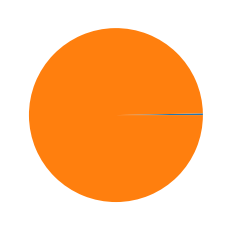

In [0]:
#乗車地点が駅のデータとそれ以外のデータとを可視化してみる
#割合が見たいため円グラフにしてみる

import numpy as np
import matplotlib.pyplot as plt

x = np.array([33228,10459275])
plt.pie(x)

割合が（想定と）大きく違っている<br>
ここで、判定Fのデータに重複があることに気づく

In [0]:
#正しい(欲しい)データを求める
#駅と判別できるデータは駅名、それ以外はNan表示のカラムを追加
#NanはNanで纏めてしまう

#クエリの作成
query_5 = """
SELECT
  station,
  before,
  after,
  statustime
FROM (
  SELECT
    CASE
      WHEN ST_CONTAINS(A.region, B.point) IS TRUE THEN A.Station_name
    ELSE
    'Nan'
  END
    AS station,
    B.before,
    B.after,
    B.StatusTime
  FROM
    `dharma-2nd-arata-naoya.dac2019.stations_terminal_region_2` AS A
  INNER JOIN (
    SELECT
      point,
      before,
      after,
      StatusTime
    FROM
      `dharma-2nd-arata-naoya.dac2019.dac2019_sample_1pml_1571663091545_OD`
    WHERE
      before = '空車'
      AND after = '実車'
    ORDER BY
      StatusTime ASC) AS B
  ON
    1 = 1)
GROUP BY
  station,
  before,
  after,
  statustime
ORDER BY
  statustime ASC
"""


#クエリ結果をpandasのデータフレームに格納
results_5 = client.query(query_5).to_dataframe()

#表示範囲を指定する
pd.set_option('display.max_rows', 10000)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_rows", 101)

#クエリ結果を表示
results_5

,station,before,after,statustime
0,Nan,空車,実車,2016-04-01 00:00:04
1,Nan,空車,実車,2016-04-01 00:00:14
2,Nan,空車,実車,2016-04-01 00:01:24
3,Nan,空車,実車,2016-04-01 00:05:15
4,Nan,空車,実車,2016-04-01 00:07:50
...,...,...,...,...
216955,Nan,空車,実車,2018-03-31 23:43:13
216956,Nan,空車,実車,2018-03-31 23:56:16
216957,赤羽,空車,実車,2018-03-31 23:56:16
216958,Nan,空車,実車,2018-03-31 23:58:45


In [0]:
#こちらもT/F/totalでカウントする
#TとFが一部重複しているため、重複部分のみ減算して表示

#クエリの作成
query_6 = """
SELECT
  COUNT(station != 'Nan'
    OR NULL) AS T,
  (COUNT(station = 'Nan'
      OR NULL) - COUNT(station != 'Nan'
      OR NULL) ) AS F,
  (COUNT(station) - COUNT(station != 'Nan'
      OR NULL)) AS total
FROM (
  SELECT
    station,
    before,
    after,
    statustime
  FROM (
    SELECT
      CASE
        WHEN ST_CONTAINS(A.region, B.point) IS TRUE THEN A.Station_name
      ELSE
      'Nan'
    END
      AS station,
      B.before,
      B.after,
      B.StatusTime
    FROM
      `dharma-2nd-arata-naoya.dac2019.stations_terminal_region_2` AS A
    INNER JOIN (
      SELECT
        point,
        before,
        after,
        StatusTime
      FROM
        `dharma-2nd-arata-naoya.dac2019.dac2019_sample_1pml_1571663091545_OD`
      WHERE
        before = '空車'
        AND after = '実車'
      ORDER BY
        StatusTime ASC) AS B
    ON
      1 = 1)
  GROUP BY
    station,
    before,
    after,
    statustime
  ORDER BY
    statustime ASC)
"""


#クエリ結果をpandasのデータフレームに格納
results_6 = client.query(query_6).to_dataframe()

#表示範囲を指定する
pd.set_option('display.max_rows', 10000)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_rows", 101)

#クエリ結果を表示
results_6

,T,F,total
0,33226,150508,183734


In [0]:
y = np.array([33226,150508])
label = ["station", "other"]
plt.pie(y, labels=label, counterclock=False, startangle=90, autopct="%.1f%%",
        pctdistance=0.5)

NameError: ignored